In [66]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.optimize import differential_evolution

import plotly.express as px
import plotly.graph_objects as go


In [67]:
import pandas as pd

data_path = "wolf_moose_nps.csv"   # sesuaikan kalau path beda
df = pd.read_csv(data_path)

# rapihin nama kolom jadi lowercase
df.columns = [c.strip().lower() for c in df.columns]
print(df.columns.tolist())
df.head()


['year', 'wolves', 'moose']


,year,wolves,moose
0,1980,50,664
1,1981,30,650
2,1982,14,700
3,1983,23,900
4,1984,24,811


In [68]:
# rapihin nama kolom: strip + lowercase
df.columns = [c.strip().lower() for c in df.columns]
print("Kolom setelah rapih:", df.columns.tolist())

required = {"year", "wolves", "moose"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Kolom wajib tidak ada: {missing}. Kolom yang ada: {df.columns.tolist()}")


Kolom setelah rapih: ['year', 'wolves', 'moose']


In [69]:
df2 = df[["year", "moose", "wolves"]].copy()
df2 = df2.rename(columns={"moose": "prey", "wolves": "predator"})
df2 = df2.sort_values("year").reset_index(drop=True)

df2.head(), df2.tail()


(   year  prey  predator
 0  1980   664        50
 1  1981   650        30
 2  1982   700        14
 3  1983   900        23
 4  1984   811        24,
     year  prey  predator
 35  2015  1250         3
 36  2016  1300         2
 37  2017  1600         2
 38  2018  1500         2
 39  2019  2060        14)

In [70]:
years = df2["year"].values.astype(int)
prey  = df2["prey"].values.astype(float)      # Moose
pred  = df2["predator"].values.astype(float)  # Wolves

print("N data:", len(df2))
print("Year range:", years.min(), "-", years.max())
print("Prey min/max:", prey.min(), prey.max())
print("Pred min/max:", pred.min(), pred.max())


N data: 40
Year range: 1980 - 2019
Prey min/max: 385.0 2400.0
Pred min/max: 2.0 50.0


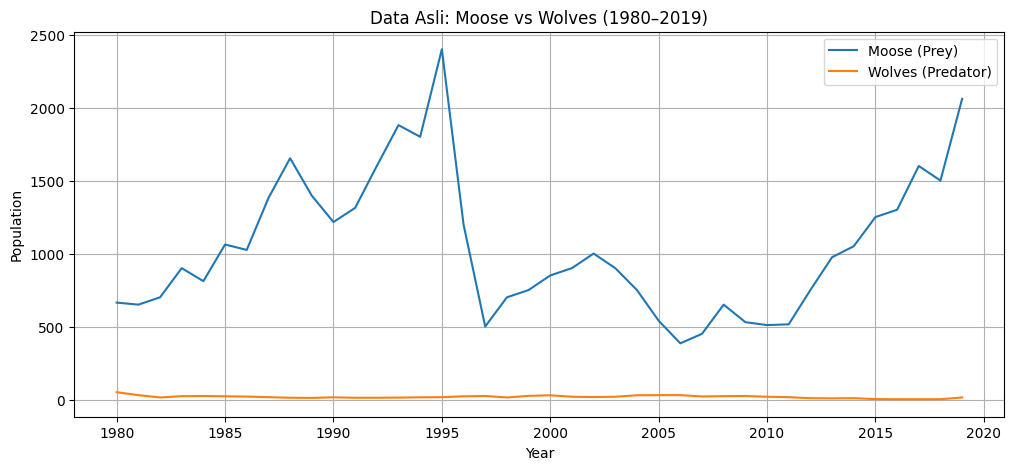

In [71]:
plt.figure(figsize=(12,5))
plt.plot(years, prey, label="Moose (Prey)")
plt.plot(years, pred, label="Wolves (Predator)")
plt.xlabel("Year")
plt.ylabel("Population")
plt.title("Data Asli: Moose vs Wolves (1980–2019)")
plt.grid(True)
plt.legend()
plt.savefig('visualizations/01_data_asli.png')
plt.show()

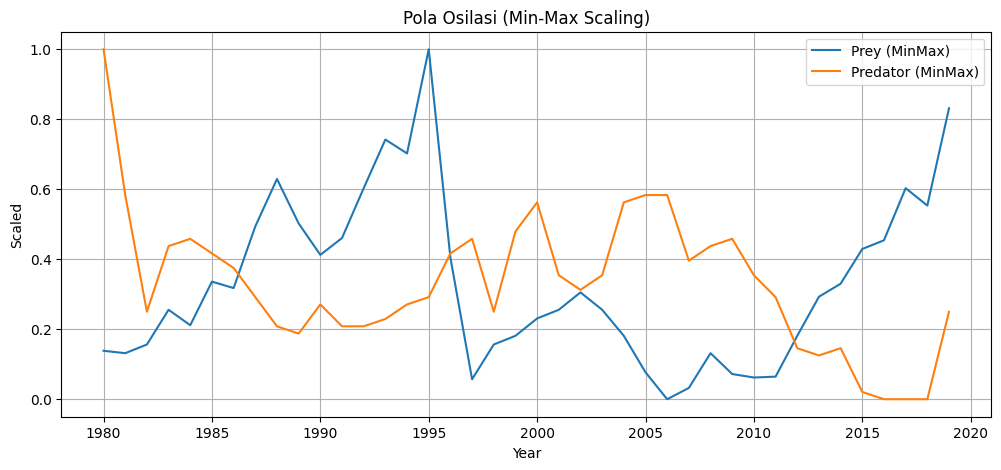

In [72]:
prey_mm = (prey - prey.min()) / (prey.max() - prey.min())
pred_mm = (pred - pred.min()) / (pred.max() - pred.min())

plt.figure(figsize=(12,5))
plt.plot(years, prey_mm, label="Prey (MinMax)")
plt.plot(years, pred_mm, label="Predator (MinMax)")
plt.xlabel("Year")
plt.ylabel("Scaled")
plt.title("Pola Osilasi (Min-Max Scaling)")
plt.grid(True)
plt.legend()
plt.savefig('visualizations/02_pola_osilasi.png')
plt.show()

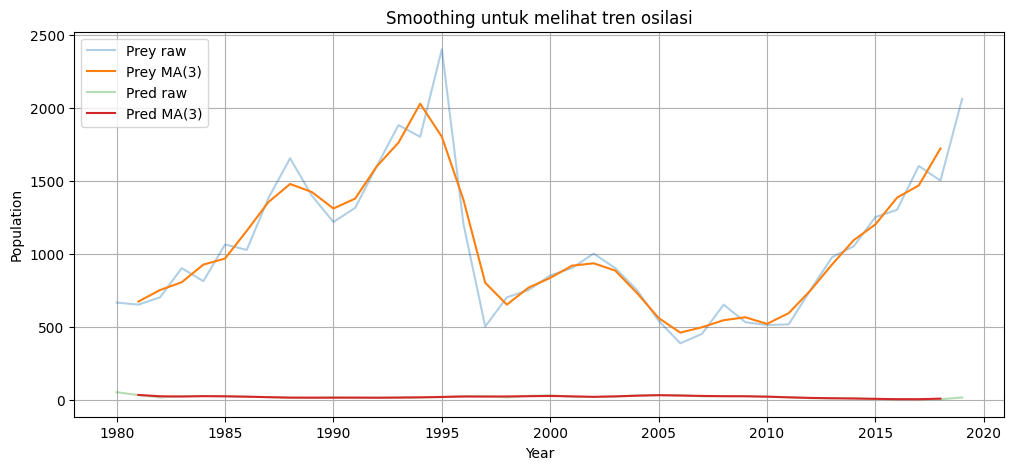

In [73]:
window = 3
prey_ma = pd.Series(prey).rolling(window, center=True).mean()
pred_ma = pd.Series(pred).rolling(window, center=True).mean()

plt.figure(figsize=(12,5))
plt.plot(years, prey, alpha=0.35, label="Prey raw")
plt.plot(years, prey_ma, label=f"Prey MA({window})")

plt.plot(years, pred, alpha=0.35, label="Pred raw")
plt.plot(years, pred_ma, label=f"Pred MA({window})")

plt.xlabel("Year")
plt.ylabel("Population")
plt.title("Smoothing untuk melihat tren osilasi")
plt.grid(True)
plt.legend()
plt.savefig('visualizations/03_smoothing_tren.png')
plt.show()

In [74]:
def lotka_volterra(t, z, alpha, beta, delta, gamma):
    x, y = z  # x=prey, y=predator
    dxdt = alpha*x - beta*x*y
    dydt = delta*x*y - gamma*y
    return [dxdt, dydt]


In [75]:
scale = max(prey.max(), pred.max())
prey_s = prey / scale
pred_s = pred / scale

t = np.arange(len(prey_s))  # 0..N-1

x0, y0 = prey_s[0], pred_s[0]
print("Initial scaled:", x0, y0)


Initial scaled: 0.27666666666666667 0.020833333333333332


In [76]:
def simulate(alpha, beta, delta, gamma):
    sol = solve_ivp(
        lotka_volterra,
        (t[0], t[-1]),
        [x0, y0],
        args=(alpha, beta, delta, gamma),
        t_eval=t,
        rtol=1e-6,
        atol=1e-8
    )
    if (not sol.success) or sol.y.shape[1] != len(t):
        return None, None
    xs, ys = sol.y[0], sol.y[1]
    if np.any(~np.isfinite(xs)) or np.any(~np.isfinite(ys)):
        return None, None
    return xs, ys


In [77]:
alpha0 = 1.0
beta0  = 1.0
delta0 = 1.0
gamma0 = 1.0

xs0, ys0 = simulate(alpha0, beta0, delta0, gamma0)
xs0[:5], ys0[:5]


(array([0.27666667, 0.74042939, 1.98732917, 5.13524507, 0.94615643]),
 array([0.02083333, 0.01227223, 0.01596851, 0.16744825, 6.29131121]))

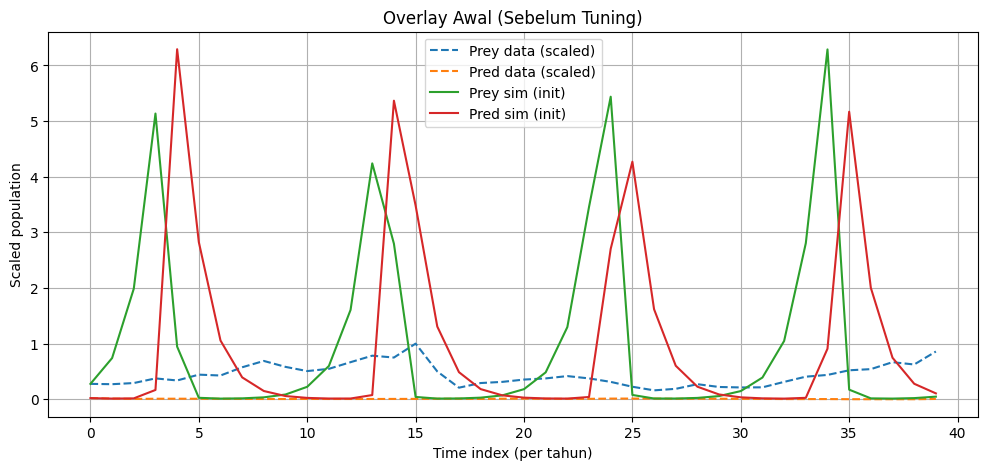

In [78]:
plt.figure(figsize=(12,5))
plt.plot(t, prey_s, "--", label="Prey data (scaled)")
plt.plot(t, pred_s, "--", label="Pred data (scaled)")

plt.plot(t, xs0, label="Prey sim (init)")
plt.plot(t, ys0, label="Pred sim (init)")

plt.title("Overlay Awal (Sebelum Tuning)")
plt.xlabel("Time index (per tahun)")
plt.ylabel("Scaled population")
plt.grid(True)
plt.legend()
plt.savefig('visualizations/04_overlay_awal.png')
plt.show()

In [79]:
def loss(params):
    alpha, beta, delta, gamma = params
    xs, ys = simulate(alpha, beta, delta, gamma)
    if xs is None or ys is None:
        return 1e9

    # BOBOT agar predator tidak kalah skala
    w_prey = 1.0
    w_pred = 3.0   # naikkan 2-5 kalau predator kurang nempel

    return w_prey*mean_squared_error(prey_s, xs) + w_pred*mean_squared_error(pred_s, ys)

In [80]:
bounds = [
    (0.001, 2.0),    # alpha
    (0.001, 30.0),   # beta  <-- dilebarin
    (0.001, 30.0),   # delta
    (0.001, 2.0)     # gamma
]

result = differential_evolution(
    loss,
    bounds,
    maxiter=250,
    popsize=25,
    tol=1e-6,
    seed=42
)

result.x, result.fun


(array([ 0.68110529, 29.9997101 ,  0.16237617,  0.07253148]),
 0.012348584690852978)

In [81]:
alpha_best, beta_best, delta_best, gamma_best = result.x
xs, ys = simulate(alpha_best, beta_best, delta_best, gamma_best)

print("Best params:")
print("alpha:", alpha_best)
print("beta :", beta_best)
print("delta:", delta_best)
print("gamma:", gamma_best)


Best params:
alpha: 0.6811052940036265
beta : 29.99971009976797
delta: 0.16237616567129773
gamma: 0.07253148125667305


MSE prey: 0.01167328973985316 | MAE prey: 0.07672759058582956
MSE pred: 0.00022509831699993972 | MAE pred: 0.014452590804274936


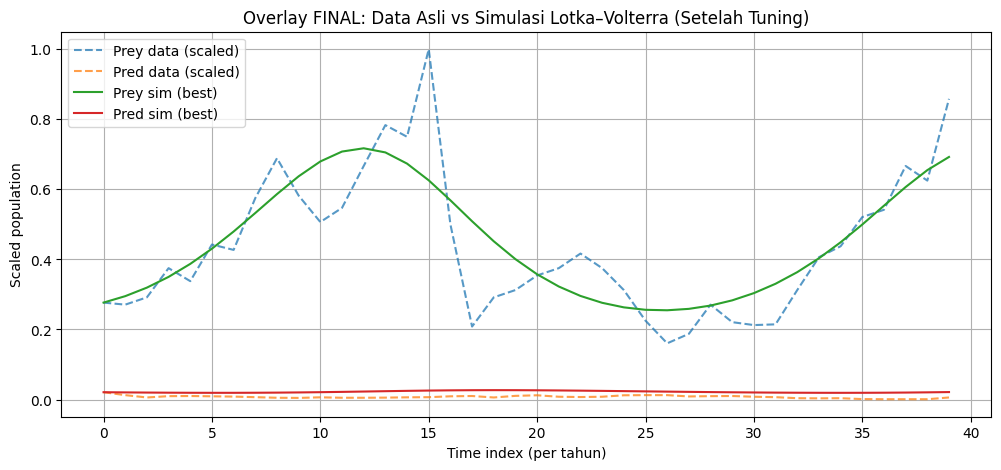

In [82]:
mse_x = mean_squared_error(prey_s, xs)
mse_y = mean_squared_error(pred_s, ys)
mae_x = mean_absolute_error(prey_s, xs)
mae_y = mean_absolute_error(pred_s, ys)

print("MSE prey:", mse_x, "| MAE prey:", mae_x)
print("MSE pred:", mse_y, "| MAE pred:", mae_y)

plt.figure(figsize=(12,5))
plt.plot(t, prey_s, "--", label="Prey data (scaled)", alpha=0.75)
plt.plot(t, pred_s, "--", label="Pred data (scaled)", alpha=0.75)

plt.plot(t, xs, label="Prey sim (best)")
plt.plot(t, ys, label="Pred sim (best)")

plt.title("Overlay FINAL: Data Asli vs Simulasi Lotka–Volterra (Setelah Tuning)")
plt.xlabel("Time index (per tahun)")
plt.ylabel("Scaled population")
plt.grid(True)
plt.legend()
plt.savefig('visualizations/05_overlay_final.png')
plt.show()

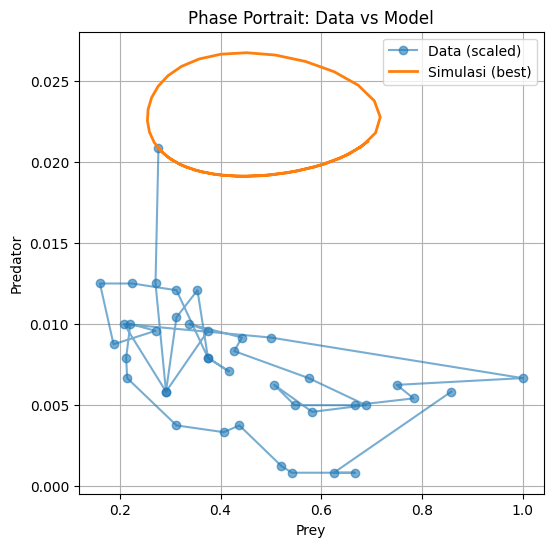

In [83]:
plt.figure(figsize=(6,6))
plt.plot(prey_s, pred_s, "o-", alpha=0.6, label="Data (scaled)")
plt.plot(xs, ys, "-", linewidth=2, label="Simulasi (best)")
plt.xlabel("Prey")
plt.ylabel("Predator")
plt.title("Phase Portrait: Data vs Model")
plt.grid(True)
plt.legend()
plt.savefig('visualizations/06_phase_portrait.png')
plt.show()

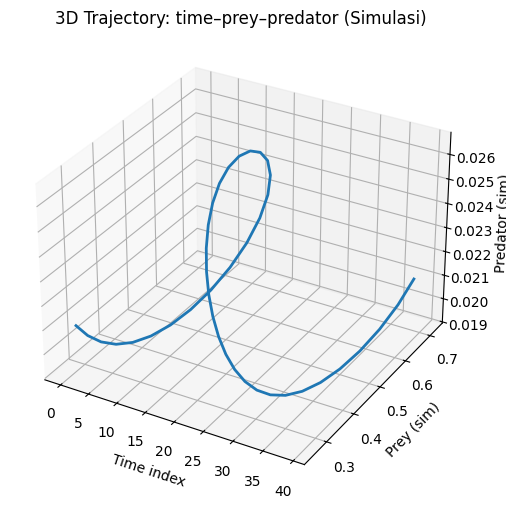

In [84]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

ax.plot(t, xs, ys, linewidth=2)
ax.set_xlabel("Time index")
ax.set_ylabel("Prey (sim)")
ax.set_zlabel("Predator (sim)")
ax.set_title("3D Trajectory: time–prey–predator (Simulasi)")
plt.savefig('visualizations/07_3d_trajectory.png')
plt.show()

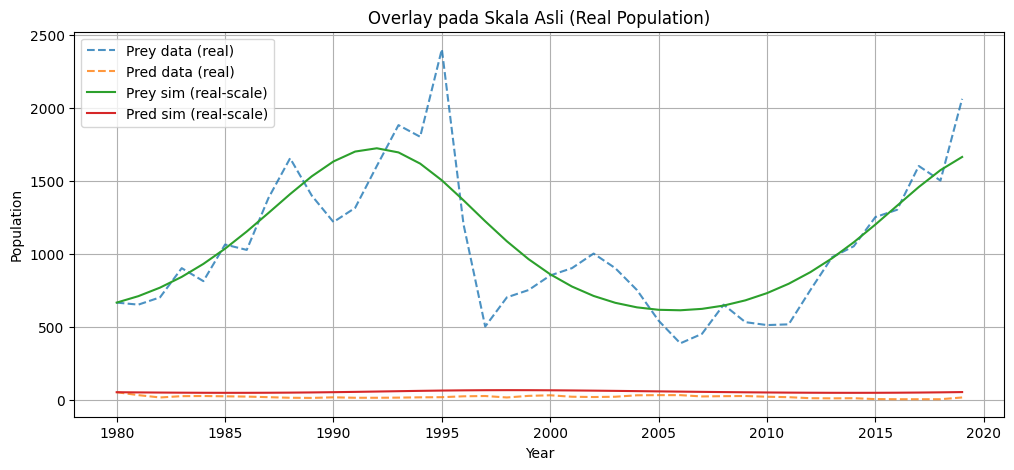

In [87]:
xs_real = xs * scale
ys_real = ys * scale

plt.figure(figsize=(12,5))
plt.plot(years, prey, "--", label="Prey data (real)", alpha=0.8)
plt.plot(years, pred, "--", label="Pred data (real)", alpha=0.8)

plt.plot(years, xs_real, label="Prey sim (real-scale)")
plt.plot(years, ys_real, label="Pred sim (real-scale)")

plt.title("Overlay pada Skala Asli (Real Population)")
plt.xlabel("Year")
plt.ylabel("Population")
plt.grid(True)
plt.legend()
plt.savefig('visualizations/08_overlay_skala_asli.png')
plt.show()